#### This notebook contains the functions used to clean the spectra.

Import Libraries

In [20]:
import pandas as pd
import numpy as np
from scipy.signal import savgol_filter
from scipy import sparse
from scipy.sparse.linalg import spsolve
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold, KFold
import seaborn as sns

Read the spectral data

In [21]:
df = pd.read_csv("../../data/exosomes.raw_spectrum_1.csv")

In [22]:
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status
0,201210-1-00,0,200.00000,2709.3699,201210-1,Normal
1,201210-1-00,1,200.68336,2697.1318,201210-1,Normal
2,201210-1-00,2,201.36674,2696.0413,201210-1,Normal
3,201210-1-00,3,202.05011,2678.5925,201210-1,Normal
4,201210-1-00,4,202.73349,2670.8928,201210-1,Normal
...,...,...,...,...,...,...
8023570,210526-3-09,2630,1997.26650,1321.0371,210526-3,Hyperglycemia
8023571,210526-3-09,2631,1997.94980,1316.4056,210526-3,Hyperglycemia
8023572,210526-3-09,2632,1998.63330,1311.2640,210526-3,Hyperglycemia
8023573,210526-3-09,2633,1999.31670,1318.0909,210526-3,Hyperglycemia


> Pivot the dataframe using WaveNumbers as features.

In [23]:
def prepare_wavelength_df(df, absorbance_col, status_col='Status'):

    # Pivot the DataFrame to get wavelengths as columns and absorbance values
    wavelength_df = df.pivot(index='SpecID', columns='WaveNumber', values=absorbance_col).reset_index()
    wavelength_df.columns.name = None

    # Merge with the statuses based on SpecID
    statuses = df[['SpecID', status_col]].drop_duplicates()
    wavelength_df = pd.merge(wavelength_df, statuses, on='SpecID')

    # Set SpecID as the index
    wavelength_df = wavelength_df.set_index('SpecID')

    return wavelength_df

>Train an Extra Trees Classifier on the Raw Spectrum and evaluate it with 10-fold cross validation.

In [24]:
def evaluate_extra_trees(df):
    # Splitting the dataframe into features (X) and target variable (y)
    X = df.drop(['Status'], axis=1)
    y = df['Status']
    
    # Creating the Extra Trees classifier
    et = ExtraTreesClassifier(random_state=1234)
    
    # Using StratifiedKFold for classification tasks
    #cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=1234)
    cv = KFold(n_splits=10, shuffle=True, random_state=1234)

    # Getting cross-validation scores
    scores = cross_val_score(et, X, y, cv=cv, scoring='accuracy')
    
    # Displaying the results
    print(f'{et.__class__.__name__} Cross-Validation Accuracy: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')

>Scale the absorbances to the highest peak in each spectrum.

In [25]:
def normalise(absorbances):
    max_value = np.max(absorbances)
    normalized_absorbances = absorbances / max_value
    return normalized_absorbances

In [26]:
def modified_z_score(ys):
    ysb = np.diff(ys) # Differentiated intensity values
    median_y = np.median(ysb) # Median of the intensity values
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ysb]) # median_absolute_deviation of the differentiated intensity values
    modified_z_scores = [0.6745 * (y - median_y) / median_absolute_deviation_y for y in ysb] # median_absolute_deviationmodified z scores
    return modified_z_scores
    
# The next function calculates the average values around the point to be replaced.
def fixer(y,ma):
    threshold = 7 # binarisation threshold
    spikes = abs(np.array(modified_z_score(y))) > threshold
    y_out = y.copy()
    for i in np.arange(len(spikes)):
        if spikes[i] != 0:
            w = np.arange(i-ma,i+1+ma)
            we = w[spikes[w] == 0]
            if len(we) > 0:  # Check if it has at least one valid value
                y_out[i] = np.mean(y[we])
    return y_out

def despike_group(absorbances):
    absorbance_data = absorbances.to_numpy()
    despiked_absorbance = fixer(absorbance_data, ma=10)
    return(despiked_absorbance)

#df['Despiked_Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x))

>Calculate the baseline using Asymmetric Least Squares, then subtract it from the spectrum.

In [27]:
def baseline_als_optimized(y, lam, p, niter=10):
    L = len(y)
    D = sparse.diags([1,-2,1],[0,-1,-2], shape=(L,L-2))
    D = lam * D.dot(D.transpose()) # Precompute this term since it does not depend on `w`
    w = np.ones(L)
    W = sparse.spdiags(w, 0, L, L)
    for i in range(niter):
        W.setdiag(w) # Do not create a new matrix, just update diagonal values
        Z = W + D
        z = spsolve(Z, w*y)
        w = p * (y > z) + (1-p) * (y < z)
    return z

#### **Select the chosen cleaning parameters then run the functions**

Choose the Parameters

In [28]:
lam = 10 ** 7
p = 0.05
window_size = 51
poly_order = 2

In [29]:
df['Absorbance'] = df.groupby('SpecID')['Absorbance'].transform(lambda x: despike_group(x))

In [30]:
df['Baseline_Corrected_Absorbance'] = df['Absorbance'] - df.groupby('SpecID')['Absorbance'].transform(lambda x: baseline_als_optimized(x, lam=lam, p=p, niter=10))

KeyboardInterrupt: 

In [ ]:
df['Smooth_Baseline_Corrected'] = df.groupby('SpecID')['Baseline_Corrected_Absorbance'].transform(lambda x: savgol_filter(x, window_size, poly_order, deriv=0))

In [ ]:
df

,SpecID,Seq,WaveNumber,Absorbance,SurID,Status,Baseline_Corrected_Absorbance,Smooth_Baseline_Corrected
0,201210-1-00,0,200.00000,2709.3699,201210-1,Normal,153.563849,134.816776
1,201210-1-00,1,200.68336,2697.1318,201210-1,Normal,144.674000,132.968432
2,201210-1-00,2,201.36674,2696.0413,201210-1,Normal,146.931751,131.193409
3,201210-1-00,3,202.05011,2678.5925,201210-1,Normal,132.831200,129.491708
4,201210-1-00,4,202.73349,2670.8928,201210-1,Normal,128.479744,127.863329
...,...,...,...,...,...,...,...,...
8023570,210526-3-09,2630,1997.26650,1321.0371,210526-3,Hyperglycemia,32.497080,21.219946
8023571,210526-3-09,2631,1997.94980,1316.4056,210526-3,Hyperglycemia,28.902013,21.661404
8023572,210526-3-09,2632,1998.63330,1311.2640,210526-3,Hyperglycemia,24.796846,22.127722
8023573,210526-3-09,2633,1999.31670,1318.0909,210526-3,Hyperglycemia,32.660178,22.618900


In [ ]:
df = df.drop(columns=['Absorbance', 'Baseline_Corrected_Absorbance'])
df = df.rename(columns={'Smooth_Baseline_Corrected':'Absorbance'})

In [ ]:
df

,SpecID,Seq,WaveNumber,SurID,Status,Absorbance
0,201210-1-00,0,200.00000,201210-1,Normal,134.816776
1,201210-1-00,1,200.68336,201210-1,Normal,132.968432
2,201210-1-00,2,201.36674,201210-1,Normal,131.193409
3,201210-1-00,3,202.05011,201210-1,Normal,129.491708
4,201210-1-00,4,202.73349,201210-1,Normal,127.863329
...,...,...,...,...,...,...
8023570,210526-3-09,2630,1997.26650,210526-3,Hyperglycemia,21.219946
8023571,210526-3-09,2631,1997.94980,210526-3,Hyperglycemia,21.661404
8023572,210526-3-09,2632,1998.63330,210526-3,Hyperglycemia,22.127722
8023573,210526-3-09,2633,1999.31670,210526-3,Hyperglycemia,22.618900


<Axes: xlabel='WaveNumber', ylabel='Absorbance'>

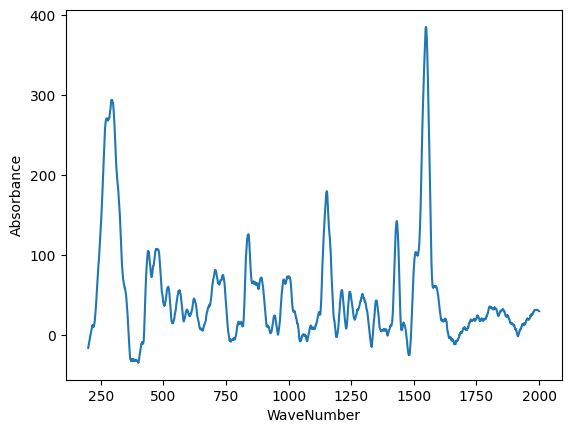

In [ ]:
sample = df[df['SpecID'] == "210526-3-06"]
sns.lineplot(x="WaveNumber", y="Absorbance", data=sample)

In [ ]:
#df.to_csv("../../data/current_clean_spectrum.csv")

In [ ]:
wavelength_df = prepare_wavelength_df(df, 'Absorbance')

In [ ]:
evaluate_extra_trees(wavelength_df)

ExtraTreesClassifier Cross-Validation Accuracy: 0.9524 +/- 0.0157
